In [ ]:
import os
import glob
import shutil
import random
import pandas as pd
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/MC886/TrabFinal/archive.zip > /dev/null

In [ ]:
!unzip /content/drive/MyDrive/MC886/TrabFinal/mask.zip > /dev/null

# Import data

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf

class Br35H(tf.keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, ids, input_img_path, target_img_path):
        tf.keras.utils.set_random_seed(42)
        self.batch_size = batch_size
        self.img_size = img_size

        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.ids = ids

        self.input_imgs = []
        self.target_imgs = []

        for id in self.ids:
            img_path = f'{self.input_img_path}{id}.jpg'
            mask_path = f'{self.target_img_path}mask_{id}.jpg'

            raw_img = np.expand_dims(np.array(load_img(img_path, target_size=self.img_size, 
                                        color_mode="grayscale")), -1)
            raw_mask = np.expand_dims(np.array(load_img(mask_path, target_size=self.img_size, 
                                         color_mode="grayscale")), -1)

            combined = np.concatenate([raw_img, raw_mask], axis=-1)

            for i in range(5):
                rotated_img, rotated_mask  = np.split(
                    tf.keras.preprocessing.image.random_rotation(combined, 30, 
                    row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant'),
                2, axis=-1)
            
                self.input_imgs.append(rotated_img)
                self.target_imgs.append(rotated_mask//255)

        """self.input_imgs = np.expand_dims(
            np.asarray([np.array(load_img(path, target_size=self.img_size, 
                    color_mode="grayscale")) for path in input_img_paths]), -1)

        self.target_imgs = np.expand_dims(
            np.asarray([np.array(load_img(path, target_size=self.img_size, 
                    color_mode="grayscale")) for path in target_img_paths]), -1)//255"""
    def __len__(self):
        return len(self.input_imgs) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        x = np.asarray(self.input_imgs[i : i + self.batch_size])
        y = np.asarray(self.target_imgs[i : i + self.batch_size])
        
        return x, y

In [ ]:
def get_paths(img_path, mask_path):
    img_paths = []
    mask_paths = []
    for path in glob.glob(img_path):
        filename = path.split('/')[-1]
        if any([filename in maskname for maskname in glob.glob(mask_path)]):
            img_paths.append(path)
            mask_paths.append(f'{mask_path[:-2]}/mask_{filename}')
    return img_paths, mask_paths

def get_ids(img_path, mask_path):
    ids = []
    for path in glob.glob(f'{img_path}*.jpg'):
        filename = path.split('/')[-1]
        if any([filename in maskname for maskname in glob.glob(f'{mask_path}*.jpg')]):
            ids.append(filename.split('.')[0])
    return ids

In [ ]:
yes_path = '/content/yes/'
mask_path = '/content/mask/'

#input_img_paths, target_img_paths = get_paths(yes_path, mask_path)
ids = get_ids(yes_path, mask_path)

from sklearn.model_selection import train_test_split

ids_train_val, ids_test= train_test_split(
                ids,
                 test_size = 0.1,
                 shuffle = True,
                 random_state = 42)

In [ ]:
dataset = Br35H(1, (224,224), ids, yes_path, mask_path)

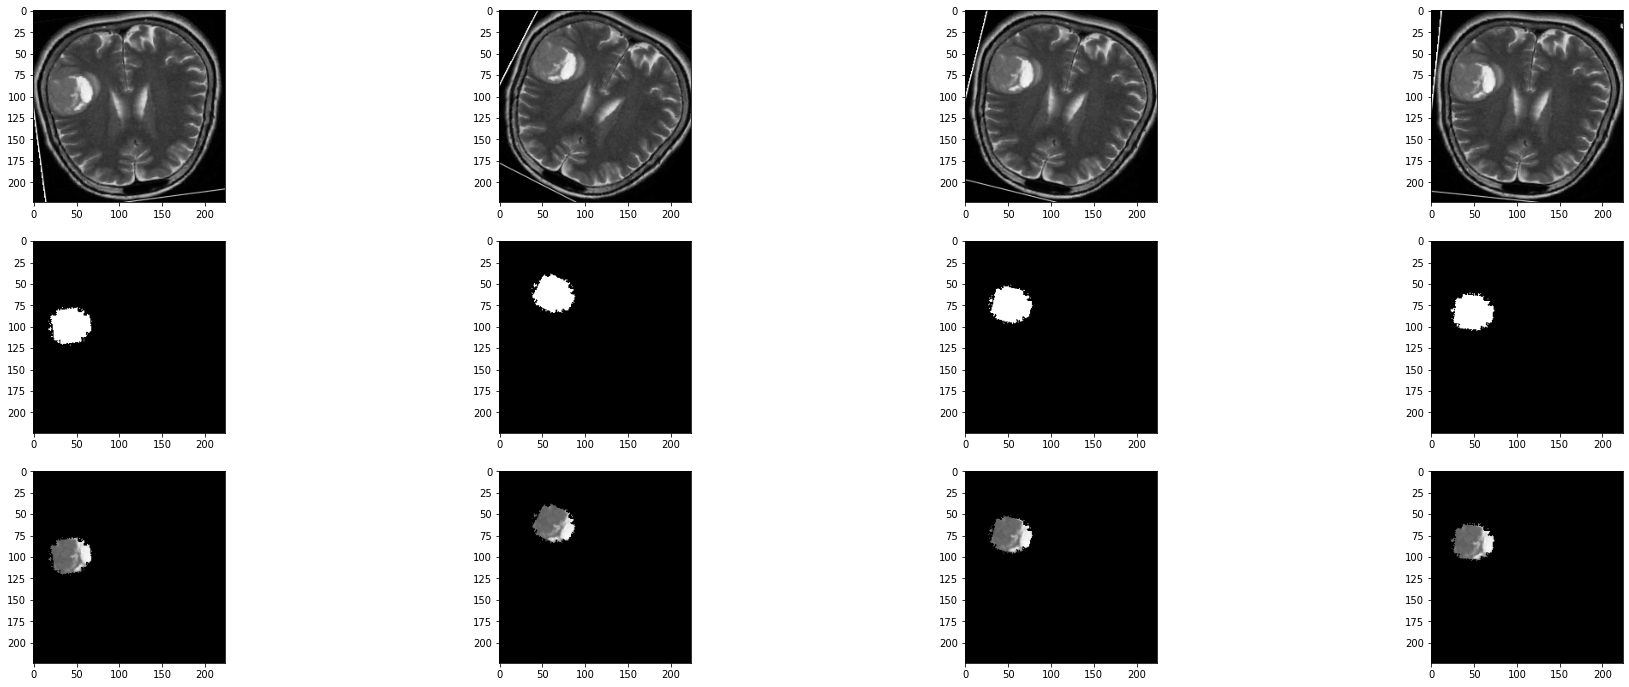

In [ ]:
f, axs = plt.subplots(3, 4, figsize=(32,12))
for i in range(4):
    image = dataset[i][0][0,:,:,0]
    mask =  dataset[i][1][0,:,:,0]
    axs[0,i].imshow(image, cmap='gray')
    axs[1,i].imshow(mask, cmap='gray')
    roi = image * mask
    axs[2,i].imshow(Image.fromarray(roi), cmap='gray')

# Model definition

In [ ]:
import keras
import keras.backend as K
from keras.metrics import AUC, Recall, Precision
from keras.models import Sequential
from keras.layers import Conv2D , MaxPooling2D, Conv2DTranspose, Concatenate, Softmax, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop


def build_model():
    inputs = tf.keras.Input(shape=(224,224,1))
    Conv_1_1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_1_1")(inputs)
    Conv_1_2 = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_1_2")(Conv_1_1)
    MaxPool_1 = MaxPooling2D(2, strides=2, name="MaxPool_1")(Conv_1_2)

    Conv_2_1 = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_2_1")(MaxPool_1)
    Conv_2_2 = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_2_2")(Conv_2_1)
    MaxPool_2 = MaxPooling2D(2, strides=2, name="MaxPool_2")(Conv_2_2)

    #Conv_3_1 = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_3_1")(MaxPool_2)
    #Conv_3_2 = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_3_2")(Conv_3_1)
    #MaxPool_3 = MaxPooling2D(2, strides=2, name="MaxPool_3")(Conv_3_2)

    #Conv_4_1 = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_4_1")(MaxPool_3)
    #Conv_4_2 = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_4_2")(Conv_4_1)
    #MaxPool_4 = MaxPooling2D(2, strides=2, name="MaxPool_4")(Conv_4_2)

    #Conv_5_1 = Conv2D(1024, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_5_1")(MaxPool_4)
    #Conv_5_2 = Conv2D(1024, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_5_2")(Conv_5_1)
    #UpConv_5 = Conv2DTranspose(512, (2,2), activation='relu', padding='same', strides=(2,2), name="UpConv_5")(Conv_5_2)

    #Concat_4 = Concatenate(axis=-1, name="Concat_4")([Conv_4_2, UpConv_5])
    #Conv_4_3 = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_4_3")(Concat_4)
    #Conv_4_4 = Conv2D(512, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_4_4")(Conv_4_3)
    #UpConv_4 = Conv2DTranspose(256, (2,2), activation='relu', padding='same', strides=(2,2), name="UpConv_4")(Conv_4_4)

    #Concat_3 = Concatenate(axis=-1, name="Concat_3")([Conv_3_2, UpConv_4])
    #Conv_3_3 = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_3_3")(Concat_3)

    Conv_3_3 = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_3_3")(MaxPool_2)
    Conv_3_4 = Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_3_4")(Conv_3_3)
    UpConv_3 = Conv2DTranspose(128, (2,2), activation='relu', padding='same', strides=(2,2), name="UpConv_3")(Conv_3_4)

    Concat_2 = Concatenate(axis=-1, name="Concat_2")([Conv_2_2, UpConv_3])
    Conv_2_3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_2_3")(Concat_2)
    Conv_2_4 = Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_2_4")(Conv_2_3)
    UpConv_2 = Conv2DTranspose(64, (2,2), activation='relu', padding='same', strides=(2,2), name="UpConv_2")(Conv_2_4)

    Concat_1 = Concatenate(axis=-1, name="Concat_1")([Conv_1_2, UpConv_2])
    Conv_1_3 = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_1_3")(Concat_1)
    Conv_1_4 = Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), name="Conv_1_4")(Conv_1_3)
    Conv_1_5 = Conv2D(2, (1,1), activation='relu', padding='same', strides=(1,1), name="logits")(Conv_1_4)

    probs = Softmax(axis=-1, name='probs')(Conv_1_5)
    segmentation = Lambda(lambda x: K.cast(K.argmax(x), dtype='float32'), name='y_pred')(probs)

    #logits_model = tf.keras.Model(inputs=inputs, outputs=Conv_1_5)
    #probs_model = tf.keras.Model(inputs=inputs, outputs=probs)
    model = tf.keras.Model(inputs=inputs, outputs=[Conv_1_5, probs, segmentation])

    return model
model = build_model()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 Conv_1_1 (Conv2D)              (None, 224, 224, 64  640         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 Conv_1_2 (Conv2D)              (None, 224, 224, 64  36928       ['Conv_1_1[0][0]']               
                                )                                                          

# Additional metrics

In [ ]:
from keras import backend as K

class_index = {'Affected': 0, 'Healthy': 1}
# So we need to invert the label in metrics

def recall_m(y_true, y_pred):
    y_true = 1-y_true
    y_pred = 1-K.cast_to_floatx(K.reshape(K.argmax(y_pred), (-1, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = 1-y_true
    y_pred = 1-K.cast_to_floatx(K.reshape(K.argmax(y_pred), (-1, 1)))
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def IoU(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    all_positives = K.sum(K.round(K.clip(y_true + y_pred, 0, 2)))

    return true_positives/all_positives

# Fitting function

In [ ]:
def Model_fit(train_data, val_data, checkpoint_prefix=""):
    
    keras_model = None
    
    keras_model = build_model()
    
    '''Compiling the model'''
    
    keras_model.compile(optimizer = RMSprop(learning_rate = 1e-4),
                        loss={"probs":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)},
                        metrics={"y_pred":IoU} )
    
    es = EarlyStopping(monitor='val_loss', mode='min',
                       patience=8,
                       restore_best_weights=True,
                       verbose=1)
                       
    
    checkpoint_cb = ModelCheckpoint(f"{checkpoint_prefix}Brain_model_best.h5",
                                    save_best_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 4,
                                  min_lr = 1e-5,
                                  mode = 'min',
                                  verbose=1)
                                  
    
    history = keras_model.fit(train_data,
                              validation_data = val_data,
                              epochs= 50,
                              batch_size = 10,
                              callbacks=[es, checkpoint_cb, reduce_lr])
                              
    
      
    return history

# Cross-Validation function

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold

k_fold = 5
IMG_SIZE = 224
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 2
tf.compat.v1.enable_eager_execution()
def CV_training(X_train_val):
    
    cv_histories = []
    
    kf = KFold(n_splits=k_fold)
    
    for i, (train_index, val_index) in enumerate(kf.split(ids_train_val)):
        ids_train = np.array(ids_train_val)[train_index]
        ids_val = np.array(ids_train_val)[val_index]

        dataset_train = Br35H(10, (224,224), ids_train, yes_path, mask_path)
        dataset_val = Br35H(10, (224,224), ids_val, yes_path, mask_path)
        
        print("Training on Fold: ",i+1)
    
        cv_histories.append(Model_fit(dataset_train, dataset_val, f"Fold_{i}_"))

    return cv_histories

cv_results = CV_training(None)

Training on Fold:  1
Epoch 1/50
288/288 [==============================] - 240s 629ms/step - loss: 0.2696 - probs_loss: 0.2696 - y_pred_IoU: 2.7551e-07 - val_loss: 0.1769 - val_probs_loss: 0.1769 - val_y_pred_IoU: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
288/288 [==============================] - 180s 627ms/step - loss: 0.1909 - probs_loss: 0.1909 - y_pred_IoU: 1.4778e-06 - val_loss: 0.1449 - val_probs_loss: 0.1449 - val_y_pred_IoU: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
288/288 [==============================] - 180s 626ms/step - loss: 0.1579 - probs_loss: 0.1579 - y_pred_IoU: 8.6728e-08 - val_loss: 0.1383 - val_probs_loss: 0.1383 - val_y_pred_IoU: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/50
288/288 [==============================] - 180s 626ms/step - loss: 0.1398 - probs_loss: 0.1398 - y_pred_IoU: 0.0000e+00 - val_loss: 0.1146 - val_probs_loss: 0.1146 - val_y_pred_IoU: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/50
288/288 [==============================] - 180s 625ms/step - loss: 0.1298 - probs_lo

# Plotting results

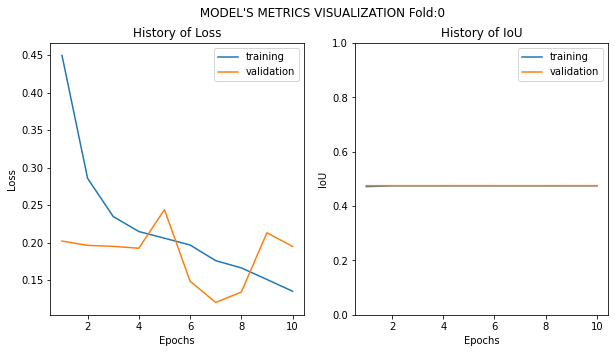

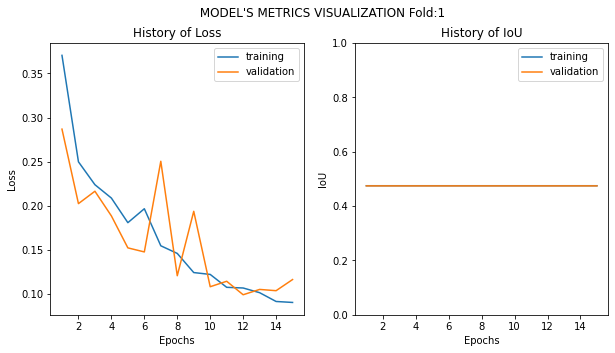

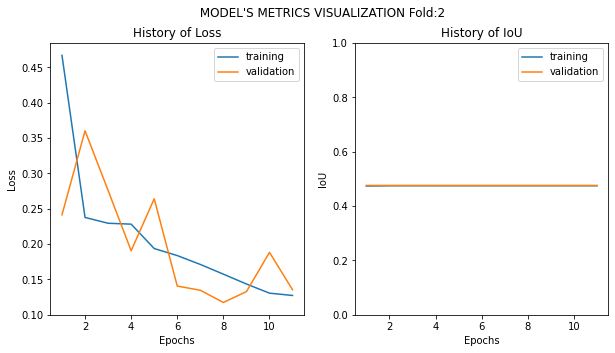

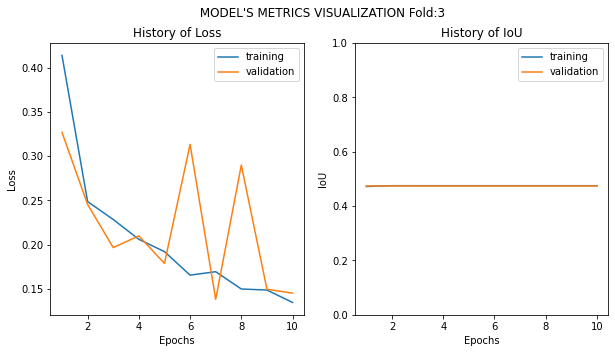

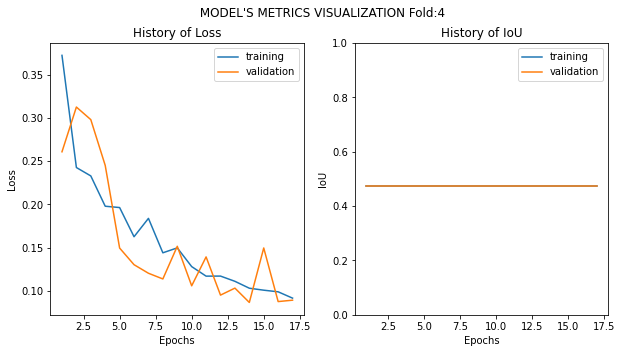

In [ ]:
def Plot(results):
    
    for i, fold in enumerate(results):

        loss = fold.history['loss']
        val_loss = fold.history['val_loss']

        iou = fold.history[f'y_pred_mean_io_u_{i+1}']
        val_iou = fold.history[f'val_y_pred_mean_io_u_{i+1}']

    
        fig, axs = plt.subplots(1,2, figsize= (10,5))
        fig.suptitle(f" MODEL'S METRICS VISUALIZATION Fold:{i}")

        def plot_metric(hist, val_hist, ax, title, y_range=None):
            ax.plot(range(1, len(hist) + 1), hist)
            ax.plot(range(1, len(val_hist) + 1), val_hist)
            ax.set_title(f'History of {title}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(title)
            ax.legend(['training', 'validation'])
            if y_range != None:
                ax.set_ylim(*y_range)


        plot_metric(loss, val_loss, axs[0], 'Loss')
        plot_metric(iou, val_iou, axs[1], 'IoU', y_range=(0,1))

        plt.show()
    
Plot(cv_results)

In [ ]:
model = cv_results[4].model

In [ ]:
output = model.predict(dataset)

(801, 224, 224, 1)


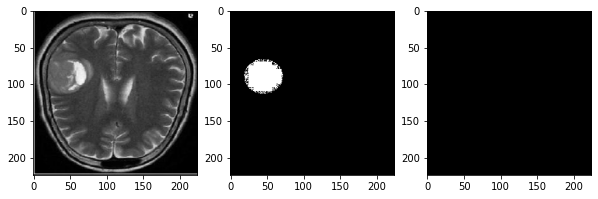

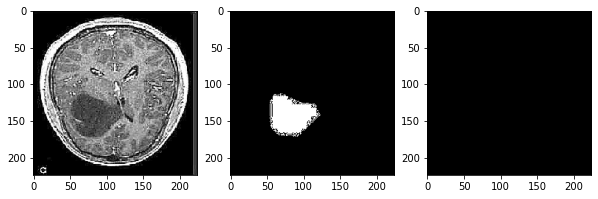

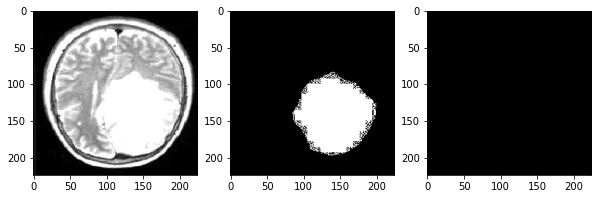

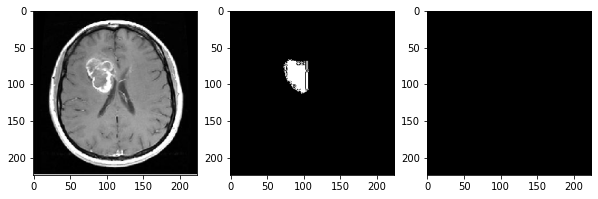

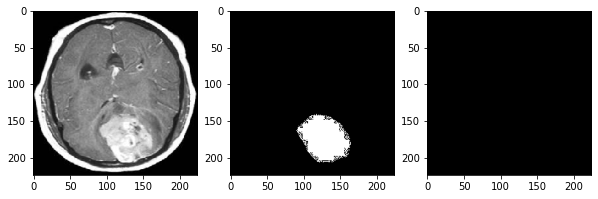

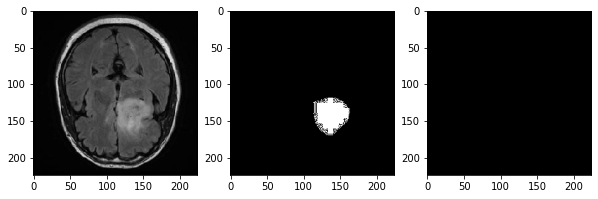

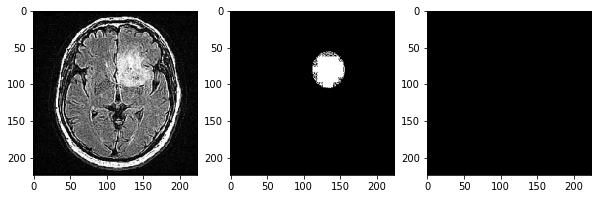

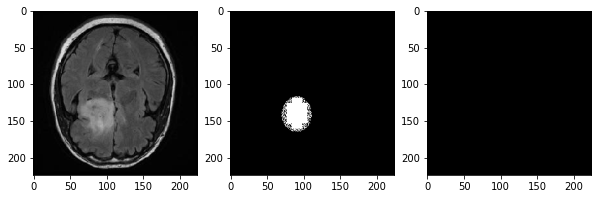

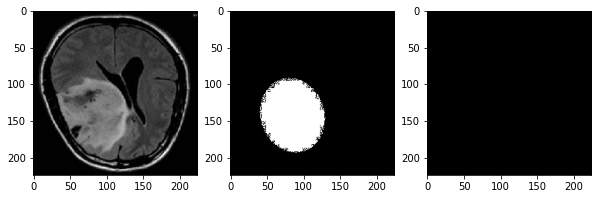

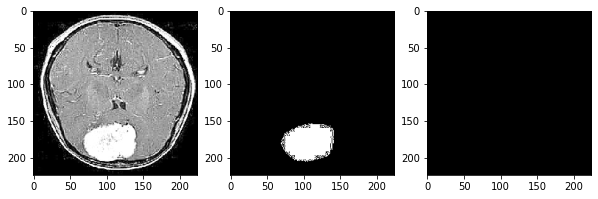

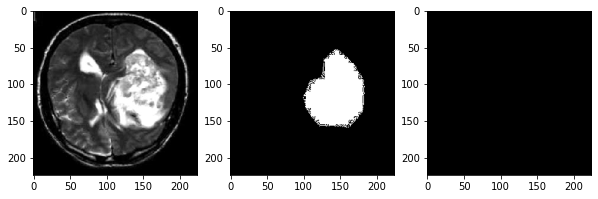

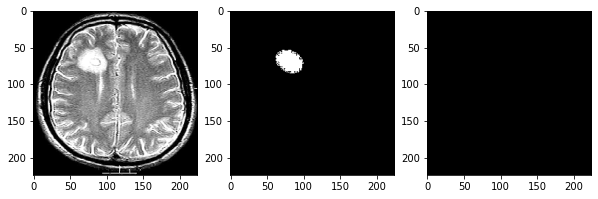

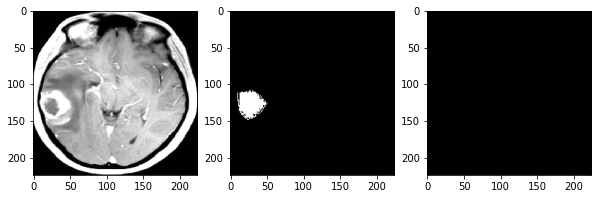

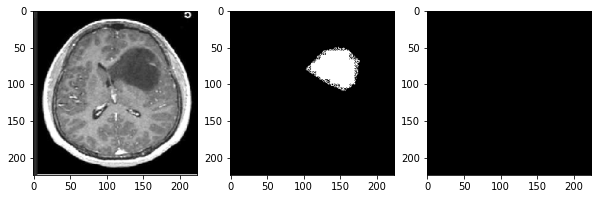

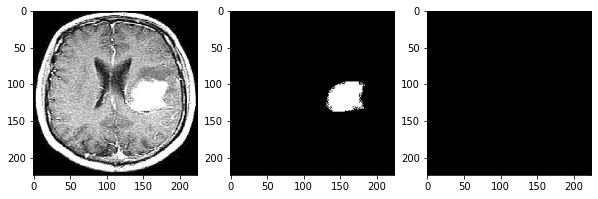

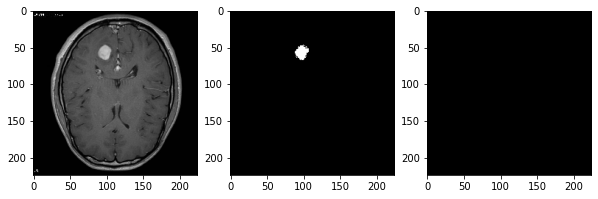

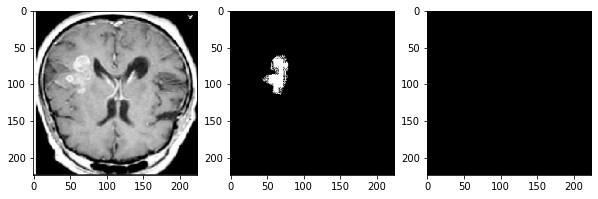

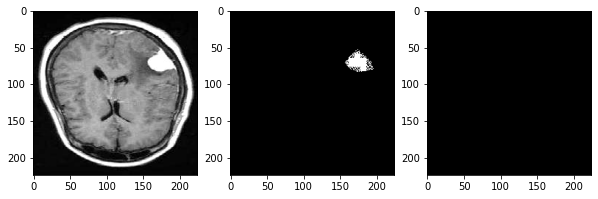

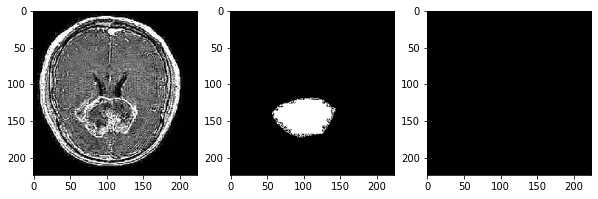

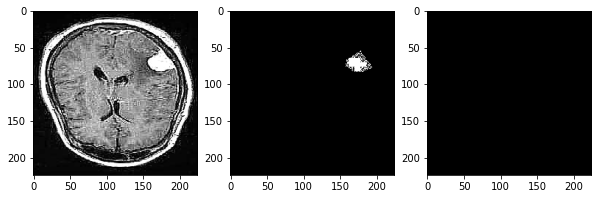

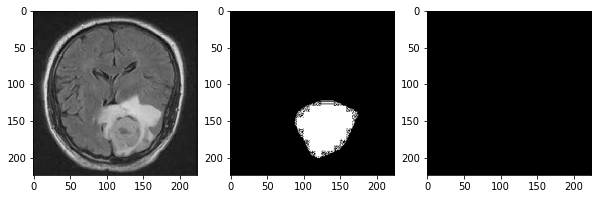

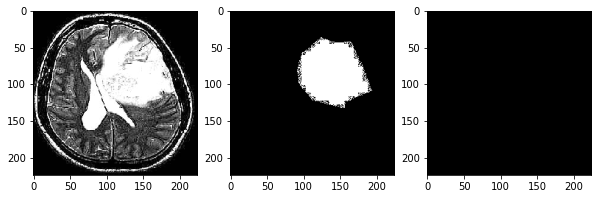

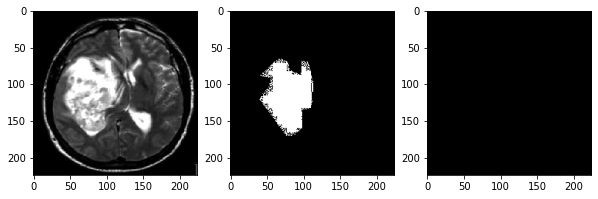

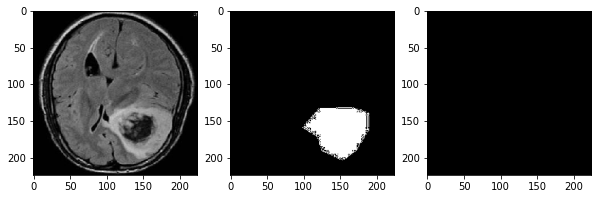

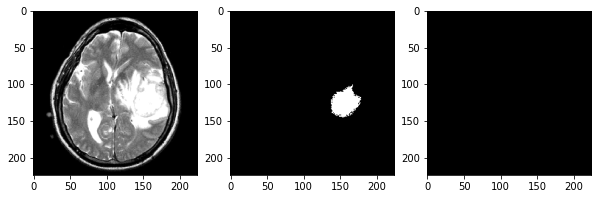

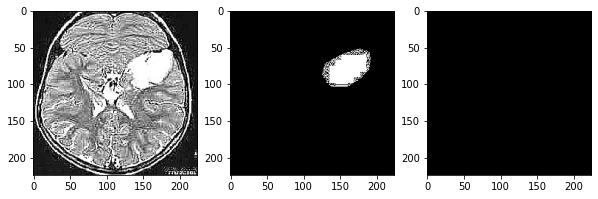

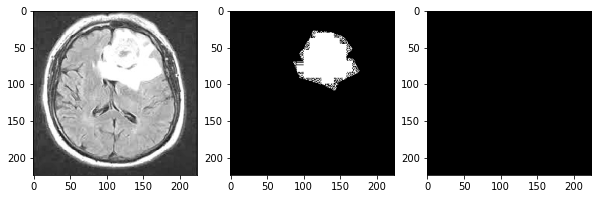

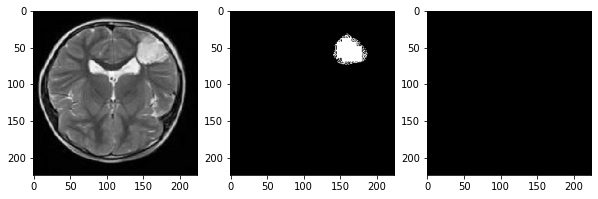

KeyboardInterrupt: ignored

In [ ]:
dataset = Br35H(1, (224,224), input_img_paths, target_img_paths)

for image, mask in dataset:
    output = model.predict(image)
    logits, probs, preds = output

    fig, axs = plt.subplots(1,3, figsize= (10,5))

    axs[0].imshow(image[0,:,:,0], cmap='gray')
    axs[1].imshow(mask[0,:,:,0], cmap='gray')
    axs[2].imshow(preds[0,:,:], cmap='gray')
    plt.show()

In [ ]:
for (logits, probs, preds) in (output):
    print(batch.shape)

(800, 224, 224, 2)
(800, 224, 224, 2)
(800, 224, 224)


In [ ]:
!mv /content/Brain_model_best.h5 /content/drive/MyDrive/MC886/TrabFinal/Brain_model_best_segmentation.h5